In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MeanShift

import warnings
warnings.filterwarnings("ignore")

from scipy.spatial import distance

In [63]:
df = pd.read_table('data/checkins.csv', sep='|')
df.columns = ['id', 'user_id', 'venue_id', 'latitude', 'longitude', 'created_at']
df.replace('                   ', np.NaN, inplace=True)
df.dropna(inplace=True)

In [64]:
df

,id,user_id,venue_id,latitude,longitude,created_at
1,984222,15824.0,5222.0,38.8951118,-77.0363658,2012-04-21 17:43:47
3,984234,44652.0,5222.0,33.800745,-84.41052,2012-04-21 17:43:43
7,984291,105054.0,5222.0,45.5234515,-122.6762071,2012-04-21 17:39:22
9,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
10,984232,93870.0,380645.0,33.4483771,-112.0740373,2012-04-21 17:38:18
...,...,...,...,...,...,...
1021959,955561,626076.0,20073.0,40.8501002,-73.8662464,2012-04-13 09:56:48
1021960,955892,674797.0,2297.0,33.7489954,-84.3879824,2012-04-13 10:56:03
1021961,956377,845102.0,11195.0,42.7653662,-71.467566,2012-04-13 12:08:45
1021962,956119,1139114.0,29488.0,42.439479,-83.7438303,2012-04-13 11:36:44


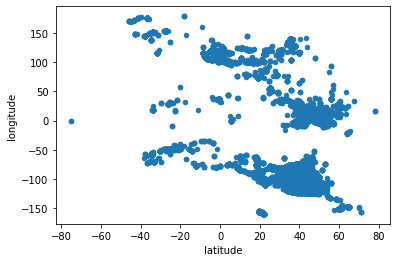

In [65]:
df[['latitude', 'longitude']].astype(float).plot.scatter(x='latitude', y='longitude')

In [66]:
model = MeanShift(bandwidth=0.1, n_jobs=-1)
model.fit_predict(df[['latitude', 'longitude']][:100000])

array([ 5,  7, 30, ..., 25, 19,  4], dtype=int64)

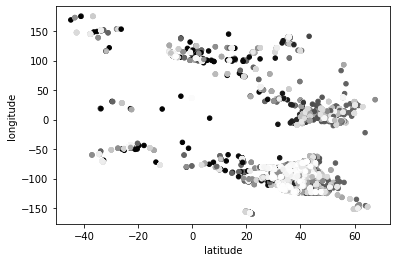

In [67]:
df[['latitude', 'longitude']][:100000].astype(float).plot.scatter(x='latitude', y='longitude', c=model.labels_)

In [129]:
df_short = df[['latitude', 'longitude']][:100000]
df_short['pred_class'] = model.labels_

value_counts = df_short['pred_class'].value_counts()
classes_to_drop = value_counts[value_counts<=15].index 
df_final = df_short[~df_short.pred_class.isin(classes_to_drop)] # drop clusters if they have less 16 elements

In [152]:
unique_clusters = pd.DataFrame(df_final.pred_class.unique(), columns=['cluster'])
unique_clusters['latitude'] = [model.cluster_centers_[x][0] for x in unique_clusters['cluster']]
unique_clusters['longitude'] = [model.cluster_centers_[x][1] for x in unique_clusters['cluster']]

In [182]:
unique_clusters

,cluster,latitude,longitude
0,5,38.886165,-77.048783
1,7,33.766636,-84.393289
2,30,45.523483,-122.676280
3,65,40.759600,-111.896078
4,1,33.449438,-112.002140
...,...,...,...
587,571,-33.050462,-71.616452
588,359,-8.664363,115.211340
589,573,50.111512,8.680506
590,342,42.016667,-94.376667


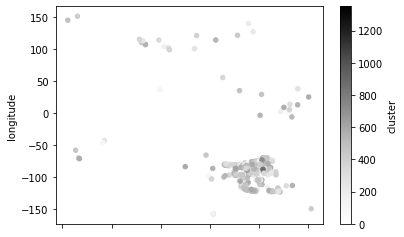

In [155]:
unique_clusters.plot.scatter(x='latitude', y='longitude', c='cluster')

In [177]:
offices = pd.DataFrame(np.array([
    [33.751277, -118.188740, "Los Angeles"],
    [25.867736, -80.324116, "Miami"],
    [51.503016, -0.075479, "London"],
    [52.378894, 4.885084, "Amsterdam"],
    [39.366487, 117.036146, "Beijing"],
    [-33.868457, 151.205134, "Sydney"]
]), columns=['lat', 'long', 'city'])

offices

,lat,long,city
0,33.751277,-118.18874,Los Angeles
1,25.867736,-80.324116,Miami
2,51.503016,-0.075479,London
3,52.378894,4.885084,Amsterdam
4,39.366487,117.036146,Beijing
5,-33.868457,151.205134,Sydney


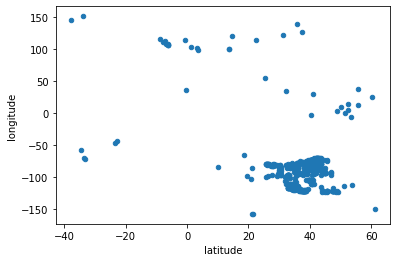

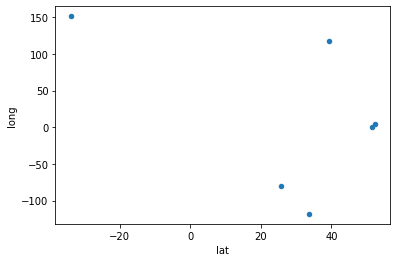

In [180]:
unique_clusters.plot.scatter(x='latitude', y='longitude')
offices[['lat', 'long']].astype(float).plot.scatter(x='lat', y='long')

In [214]:
result = []

for cluster in unique_clusters.values:
    for office in offices.values:
        x = [float(cluster[1]), float(cluster[2])]
        y = [float(office[0]), float(office[1])]
        dist = distance.euclidean(x, y)
        result.append([cluster[0], cluster[1], cluster[2], office[2], dist])

In [219]:
result.sort(key=lambda x: x[4])
pd.DataFrame(result, columns=['cluster', 'lat', 'long', 'city', 'distance'])

,cluster,lat,long,city,distance
0,420.0,-33.860630,151.204776,Sydney,0.007835
1,370.0,52.372964,4.892317,Amsterdam,0.009353
2,419.0,25.845672,-80.318891,Miami,0.022674
3,58.0,51.502991,-0.125537,London,0.050058
4,51.0,33.809878,-118.148924,Los Angeles,0.070848
...,...,...,...,...,...
3547,69.0,49.240172,-123.111860,Sydney,286.630176
3548,539.0,48.433061,-123.361905,Sydney,286.636701
3549,172.0,21.305571,-157.856817,Sydney,313.948185
3550,403.0,21.377810,-158.003045,Sydney,314.104836


In [221]:
with open('result.txt', 'w') as file:
    file.write(f'{result[0][1]} {result[0][2]}')